### Imports

In [715]:
%pip install matplotlib
%pip install prophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from datetime import datetime
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse, rmse, meanabs, aic, bic
from pmdarima import auto_arima
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.arima.model import ARIMA
from statistics import median,mean
import matplotlib.ticker as ticker
import pytz
import warnings
import scipy.stats as st
import math
import seaborn as sns
from pylab import rcParams
warnings.filterwarnings('ignore')

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Ingest Data

In [716]:
data = pd.read_csv("../data/airlinetweets.csv", parse_dates=['tweet_created'], index_col=['tweet_created'])
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_location,user_timezone
tweet_created,,,,,,,,,,,,,,
2015-02-24 11:35:52-08:00,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,NaN,Eastern Time (US & Canada)
2015-02-24 11:15:59-08:00,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,NaN,Pacific Time (US & Canada)
2015-02-24 11:15:48-08:00,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,Lets Play,Central Time (US & Canada)
2015-02-24 11:15:36-08:00,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,NaN,Pacific Time (US & Canada)
2015-02-24 11:14:45-08:00,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-22 12:01:01-08:00,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,NaN,NaN
2015-02-22 11:59:46-08:00,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,Texas,NaN
2015-02-22 11:59:15-08:00,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,"Nigeria,lagos",NaN


## Data Exploratory Analysis

In [717]:
data.describe()
data_summary = data.groupby('airline_sentiment').resample('1d').count()[['tweet_id']]
data_summary = data_summary.unstack(0)
data_summary['total'] = data_summary.sum(axis = 1)
data_summary['tweet_id']['negative'].sum()

data_summary

tweet_id                    total
airline_sentiment         negative neutral positive        
tweet_created                                              
2015-02-16 00:00:00-08:00      3.0     1.0      NaN     4.0
2015-02-17 00:00:00-08:00    838.0   297.0    273.0  1408.0
2015-02-18 00:00:00-08:00    736.0   335.0    273.0  1344.0
2015-02-19 00:00:00-08:00    751.0   329.0    296.0  1376.0
2015-02-20 00:00:00-08:00    835.0   383.0    282.0  1500.0
2015-02-21 00:00:00-08:00   1049.0   278.0    230.0  1557.0
2015-02-22 00:00:00-08:00   2266.0   463.0    350.0  3079.0
2015-02-23 00:00:00-08:00   1919.0   676.0    433.0  3028.0
2015-02-24 00:00:00-08:00    781.0   337.0    226.0  1344.0

### Get Summary of Data

### Resample the data

In [718]:
#Resample the data
data['sentiment']=data['airline_sentiment'].map({'positive':1,'neutral':0,'negative':-1}) 
actual_positive_sentiments = data[data['sentiment']==1].resample('10min').count()
actual_negative_sentiments = data[data['sentiment']==-1].resample('10min').count()
actual_neutral_sentiments = data[data['sentiment']==0].resample('10min').count()
actual_negative_sentiments['sentiment'].tail(50)

tweet_created
2015-02-24 03:40:00-08:00    12
2015-02-24 03:50:00-08:00     5
2015-02-24 04:00:00-08:00     8
2015-02-24 04:10:00-08:00     8
2015-02-24 04:20:00-08:00    10
2015-02-24 04:30:00-08:00     9
2015-02-24 04:40:00-08:00    12
2015-02-24 04:50:00-08:00    11
2015-02-24 05:00:00-08:00     8
2015-02-24 05:10:00-08:00     5
2015-02-24 05:20:00-08:00    10
2015-02-24 05:30:00-08:00    10
2015-02-24 05:40:00-08:00     7
2015-02-24 05:50:00-08:00     7
2015-02-24 06:00:00-08:00    10
2015-02-24 06:10:00-08:00    16
2015-02-24 06:20:00-08:00     7
2015-02-24 06:30:00-08:00    10
2015-02-24 06:40:00-08:00     8
2015-02-24 06:50:00-08:00    17
2015-02-24 07:00:00-08:00     7
2015-02-24 07:10:00-08:00    15
2015-02-24 07:20:00-08:00     8
2015-02-24 07:30:00-08:00    12
2015-02-24 07:40:00-08:00    20
2015-02-24 07:50:00-08:00    13
2015-02-24 08:00:00-08:00    15
2015-02-24 08:10:00-08:00     7
2015-02-24 08:20:00-08:00    12
2015-02-24 08:30:00-08:00    15
2015-02-24 08:40:00-08:00 

### Standardize the data

In [719]:
# Standardize the data
standard_scaler_positive_sentiment = StandardScaler()
standard_scaler_negative_sentiment = StandardScaler()
standard_scaler_neutral_sentiment = StandardScaler()

actual_positive_sentiments[['sentiment_normalized']] = \
    standard_scaler_positive_sentiment.fit_transform(actual_positive_sentiments[['sentiment']])
actual_negative_sentiments[['sentiment_normalized']] = \
    standard_scaler_negative_sentiment.fit_transform(actual_negative_sentiments[['sentiment']])
actual_neutral_sentiments[['sentiment_normalized']] = \
    standard_scaler_neutral_sentiment.fit_transform(actual_neutral_sentiments[['sentiment']])

### Test for stationarity

In [720]:
adfuller(actual_negative_sentiments['sentiment_normalized'])

(-2.998544526534612,
 0.03503054692717735,
 7,
 1074,
 {'1%': -3.4364533503600962,
  '5%': -2.864234857527328,
  '10%': -2.568204837482531},
 1716.8658021129845)

p-value is less than 0.05% - should imply stationarity

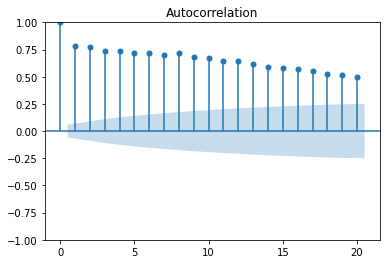

In [721]:
plot_acf(actual_negative_sentiments['sentiment'], lags=20);

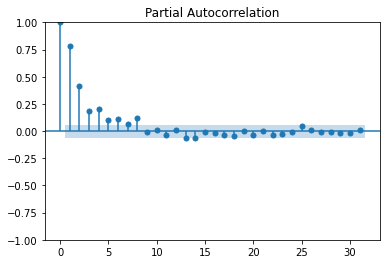

In [722]:
plot_pacf(actual_negative_sentiments['sentiment_normalized']);

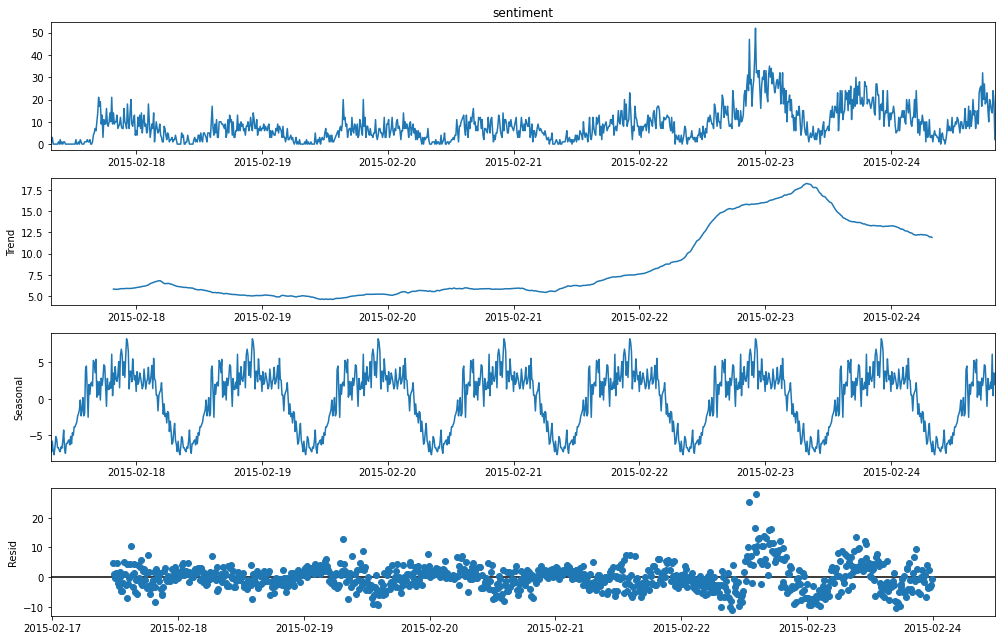

In [723]:
rcParams['figure.figsize'] = (14, 9)
the_decompose = seasonal_decompose(actual_negative_sentiments['sentiment'],model='additive',period=144);
the_decompose.plot();

### Plot Data

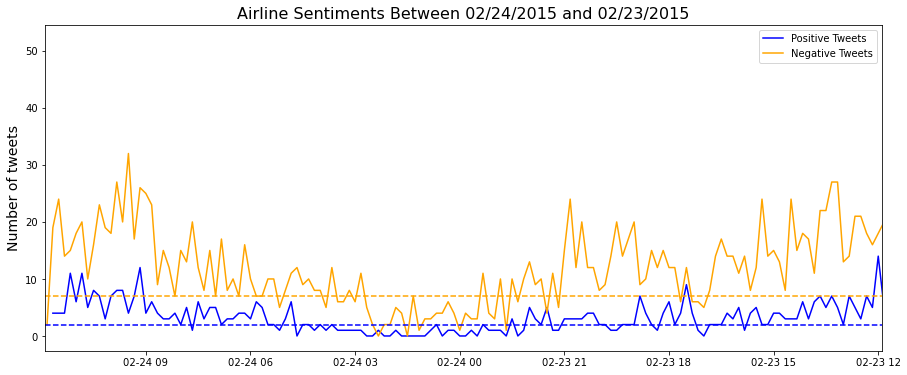

In [724]:
start_date, end_date = data['sentiment'].index.max(), data['sentiment'].index.min()

start_date, end_date = data['sentiment'].index.max(), data['sentiment'].index.max() - timedelta(days=1)

plt.figure(figsize=(15,6))
plt.title(f"Airline Sentiments Between {datetime.strftime(start_date, '%m/%d/%Y')} and {datetime.strftime(end_date, '%m/%d/%Y')}", fontsize=16)
plt.ylabel('Number of tweets', fontsize=14)

plt.xlim(start_date, end_date)

plt.plot(actual_positive_sentiments['sentiment'],
         label="Positive Tweets", color="blue")
plt.plot(actual_negative_sentiments['sentiment'],
         label="Negative Tweets", color="orange")

plt.axhline(actual_positive_sentiments['sentiment'].median(), linestyle='--', color='blue')
plt.axhline(actual_negative_sentiments['sentiment'].median(), linestyle='--', color='orange')

plt.legend()

# Training

### Generate an ARIMA model

In [725]:
# Search for best-fit parameters
stepwise_fit = auto_arima(actual_negative_sentiments['sentiment_normalized'],start_p=0,start_q=0,max_p=6,max_q=6,
                          seasonal=False,trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2170.115, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1897.800, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1749.332, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2168.115, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1750.821, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1750.880, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1747.656, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1744.630, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1750.880, Time=0.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1746.330, Time=0.50 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1746.458, Time=0.99 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1744.466, Time=0.62 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1750.220, Time=0.33 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1746.452, Time=0.54 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1082
Model:               SARIMAX(3, 1, 4)   Log Likelihood                -861.263
Date:                Wed, 27 Jul 2022   AIC                           1738.526
Time:                        05:33:34   BIC                           1778.411
Sample:                             0   HQIC                          1753.628
                               - 1082                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5052      0.157      3.214      0.001       0.197       0.813
ar.L2          0.6717      0.113      5.924      0.000       0.449       0.894
ar.L3         -0.5073      0.143     -3.538      0.000      -0.788      -0.226
ma.L1         -1.2022      0.168     -7.176      0.000      -1.531      -0.874
ma.L2         -0.3134      0.188     -1.668      0.095      -0.682       0.055
ma.L3          0.8769      0.201      4.373      0.000       0.484       1.270
ma.L4         -0.2518      0.117     -2.145      0.032      -0.482      -0.022
sigma2         0.2876      0.009     33.825      0.000       0.271       0.304
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               502.61
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.64   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Train

In [726]:
test_len = 24*6

actual_negative_sentiments_train = actual_negative_sentiments.iloc[:-test_len]
actual_negative_sentiments_test = actual_negative_sentiments.iloc[-test_len:]

model_ARIMA = ARIMA(actual_negative_sentiments_train['sentiment_normalized'], order=(3,1,4)) 
model_ARIMA_results = model_ARIMA.fit() #fit the model

### Detect Anomalies

In [787]:
z_score = st.norm.ppf(.95) #95% confidence interval
mae_scale_factor = 0.67449 # MAE is 0.67449 * std
mae = median_absolute_error(model_ARIMA_results.fittedvalues,actual_negative_sentiments_train['sentiment_normalized'])

threshold = median(model_ARIMA_results.fittedvalues) + (z_score/mae_scale_factor)*mae
model_ARIMA_results_metrics = \
    pd.DataFrame({ 'fittedvalues' : model_ARIMA_results.fittedvalues, \
      'median_values' : model_ARIMA_results.fittedvalues.rolling(4).median().fillna(0)}, \
       index = model_ARIMA_results.fittedvalues.index )
model_ARIMA_results_metrics['threshold'] = model_ARIMA_results_metrics['median_values'] + (z_score/mae_scale_factor)*mae
model_ARIMA_results_metrics['anomaly'] = 0
model_ARIMA_results_metrics['actualvalues'] = actual_negative_sentiments_train['sentiment_normalized']
model_ARIMA_results_metrics.loc[model_ARIMA_results_metrics['actualvalues'] > model_ARIMA_results_metrics['threshold'],'anomaly']= 1
model_ARIMA_results_metrics['anomaly'].value_counts()

0    840
1     98
Name: anomaly, dtype: int64

### Plot Anomalies

Text(0.5, 1.0, 'ARIMA Model (Train): \n Median Absolute Error (MAE): 1.9212819457584622')

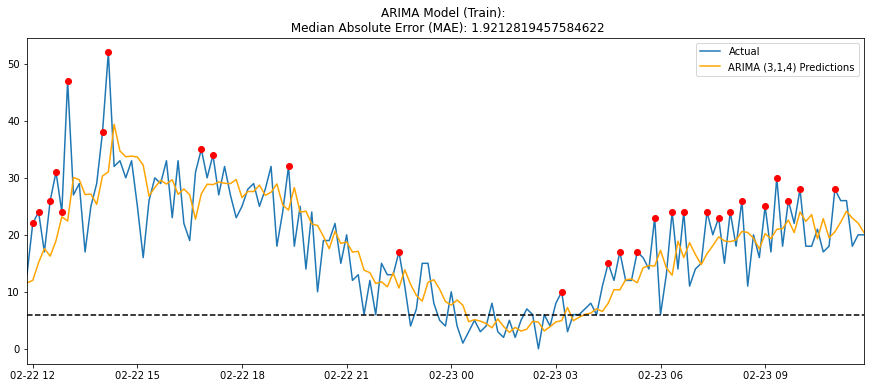

In [789]:
#start_date, end_date = actual_negative_sentiments_train.index[0], actual_negative_sentiments_train.index[-1]
start_date, end_date = actual_negative_sentiments_train.index[-1] - timedelta(hours=24), actual_negative_sentiments_train.index[-1]
#start_date, end_date = actual_negative_sentiments_train.index[0], actual_negative_sentiments_train.index[0] + timedelta(days=1)

#fitted_values_actual = pd.Series(\
#        standard_scaler_negative_sentiment.inverse_transform(actual_negative_sentiments_train['sentiment_normalized']),\
#        index = actual_negative_sentiments_train['sentiment_normalized'].index)
#fitted_values_predicted = pd.Series(\
#        standard_scaler_negative_sentiment.inverse_transform(model_ARIMA_results.fittedvalues),\
#        index = actual_negative_sentiments_train['sentiment_normalized'].index)
fitted_values_actual = pd.Series(\
        standard_scaler_negative_sentiment.inverse_transform(model_ARIMA_results_metrics.actualvalues),\
        index = model_ARIMA_results_metrics.actualvalues.index)
fitted_values_predicted = pd.Series(\
        standard_scaler_negative_sentiment.inverse_transform(model_ARIMA_results_metrics.fittedvalues),\
        index = model_ARIMA_results_metrics.fittedvalues.index)

median_value = median(fitted_values_actual)
median_value_predicted = median(fitted_values_predicted)
mean_value_actual = mean(fitted_values_actual)
mean_value_predicted = mean(fitted_values_predicted)
mae_error = median_absolute_error(fitted_values_predicted,fitted_values_actual)
rms_error = rmse(fitted_values_predicted,fitted_values_actual)

plt.figure(figsize=(15,6))
plt.xlim(start_date, end_date)
plt.plot(fitted_values_actual, label="Actual")
plt.plot(fitted_values_predicted, color='orange', label="ARIMA (3,1,4) Predictions")
plt.plot(fitted_values_actual.loc[model_ARIMA_results_metrics['anomaly']==1], \
        marker='o', linestyle='None', color='red'
    )
plt.axhline(median_value, linestyle='--', color='k')
plt.legend()

plt.title(f"ARIMA Model (Train): \n Median Absolute Error (MAE): {mae_error}")

2015-02-23 12:00:00-08:00    1.902801
2015-02-23 12:10:00-08:00    1.434923
2015-02-23 12:20:00-08:00    1.445388
2015-02-23 12:30:00-08:00    1.711432
2015-02-23 12:40:00-08:00    1.731238
                               ...   
2015-02-24 11:10:00-08:00    1.577029
2015-02-24 11:20:00-08:00    1.361371
2015-02-24 11:30:00-08:00    0.670884
2015-02-24 11:40:00-08:00    1.387735
2015-02-24 11:50:00-08:00    1.606540
Freq: 10T, Length: 144, dtype: float64

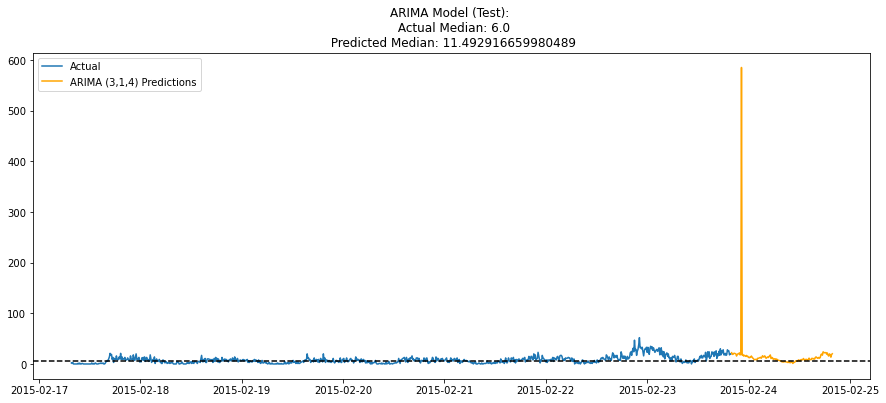

In [729]:
#start_date, end_date = actual_negative_sentiments_test.index[0], actual_negative_sentiments_test.index[-1]

# Run against test dataset
#for index, row in actual_negative_sentiments_test.iterrows():
#forecast_window_size = len(actual_negative_sentiments_test) 
#forecast_window_end = len(actual_negative_sentiments_train) # - forecast_window_size
#predictions = pd.Series([])

for idx in np.arange(forecast_window_size):
    end_idx = forecast_window_end + idx
    start_idx = (end_idx - 1) - forecast_window_size
    
    tmp_data = actual_negative_sentiments.iloc[start_idx:end_idx]
    tmp_ARIMA = ARIMA(tmp_data['sentiment_normalized'], order=(3,1,4)) 
    tmp_model_ARIMA_results = tmp_ARIMA.fit()
    pred = tmp_model_ARIMA_results.forecast(typ="levels").rename('forecasted')
    predictions = predictions.append(pred)
    

fitted_values_actual = pd.Series(\
        standard_scaler_negative_sentiment.inverse_transform(actual_negative_sentiments_train['sentiment_normalized']),\
        index = actual_negative_sentiments_train['sentiment_normalized'].index)
fitted_values_predicted = pd.Series(standard_scaler_negative_sentiment.inverse_transform(predictions), index = predictions.index)

median_value = median(fitted_values_actual)
median_value_predicted = median(fitted_values_predicted)
mean_value = mean(fitted_values_actual)
mean_value_predicted = mean(fitted_values_predicted)
#mae_error = median_absolute_error(fitted_values_predicted,fitted_values_actual)
#rms_error = rmse(fitted_values_predicted,fitted_values_actual)
    

#Plot curves
plt.figure(figsize=(15,6))
#plt.xlim(start_date, end_date)
plt.plot(fitted_values_actual, label="Actual")
plt.plot(fitted_values_predicted, color='orange', label="ARIMA (3,1,4) Predictions")
plt.axhline(median_value, linestyle='--', color='k')
plt.legend()

plt.title(f"ARIMA Model (Test): \n Actual Median: {median_value}\n Predicted Median: {median_value_predicted}")
    
predictions

In [731]:
tmp_data = actual_negative_sentiments_test.iloc[start_idx:end_idx]
    tmp_ARIMA = ARIMA(tmp_data['sentiment_normalized'], order=(3,1,4)) 
    tmp_model_ARIMA_results = tmp_ARIMA.fit()
    actual_negative_sentiments_test.iloc[end_idx] = \
        tmp_model_ARIMA_results.predict(end_idx,end_idx+1,typ="levels").rename('forecasted')

    fitted_values_actual = pd.Series(\
            standard_scaler_negative_sentiment.inverse_transform(actual_negative_sentiments_test['sentiment_normalized']),\
            index = actual_negative_sentiments_test['sentiment_normalized'].index)
    fitted_values_predicted = pd.Series(\
            standard_scaler_negative_sentiment.inverse_transform(model_ARIMA_results_test),\
            index = actual_negative_sentiments_test['sentiment_normalized'].index)

    median_value = median(fitted_values_actual)
    median_value_predicted = median(fitted_values_predicted)
    mean_value = mean(fitted_values_actual)
    mean_value_predicted = mean(fitted_values_predicted)
    mae_error = median_absolute_error(fitted_values_predicted,fitted_values_actual)
    rms_error = rmse(fitted_values_predicted,fitted_values_actual)
    

#Plot curves
plt.figure(figsize=(15,6))
plt.xlim(start_date, end_date)
plt.plot(fitted_values_actual, label="Actual")
plt.plot(fitted_values_predicted, color='orange', label="ARIMA (3,1,4) Predictions")
plt.axhline(median_value, linestyle='--', color='k')
plt.legend()

plt.title(f"ARIMA Model (Test): \n Actual Median: {median_value}\n Predicted Median: {median_value_predicted}\nMAE (Median Absolute Error): {mae_error}")
    

IndentationError: unexpected indent (2190386993.py, line 2)

# Forecasting

In [ ]:
start = len(actual_negative_sentiments['sentiment_normalized'])
end = start + (7 * 24 * 6) # 7 days in 10-minute intervals

model_ARIMA_forecast_results = ARIMA(actual_negative_sentiments['sentiment_normalized'], order=(3,1,4)).fit()
model_ARIMA_predictions = model_ARIMA_forecast_results.predict(start,end,typ="levels").rename('forecasted')
model_ARIMA_predictions

### Plot Forecasted vs Actual

In [ ]:
#start_date, end_date = actual_negative_sentiments.index[0], actual_negative_sentiments.index[-1]
#start_date, end_date = actual_negative_sentiments.index[-1]-timedelta(days=2), \
#                        model_ARIMA_predictions.index[0]+timedelta(days=12)

fitted_values_forecasted = pd.Series(standard_scaler_negative_sentiment.inverse_transform(model_ARIMA_predictions),
                            index=model_ARIMA_predictions.index)

plt.figure(figsize=(15,6))
#plt.xlim(start_date, end_date)
plt.plot(fitted_values_actual, label='Actual')
plt.plot(fitted_values_forecasted, color='orange', label='ARIMA (3,1,4) Forecast')
plt.title('Forecasted vs Actual')
plt.legend()

# Utilities

In [ ]:
fitted_values_forecasted.median()

In [ ]:
fitted_values_actual.median()

In [ ]:
actual_negative_sentiments['sentiment'].rolling(144).mean().plot()